# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [24]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [25]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [118]:
data = pd.read_csv('/content/ratings_Electronics.csv')

In [119]:
data.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [120]:
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045142 entries, 0 to 5045141
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   prod_id    object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 154.0+ MB


In [122]:
data.drop('timestamp', axis=1, inplace=True)

In [123]:
df=data.copy()

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045142 entries, 0 to 5045141
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 115.5+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [125]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [126]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [127]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [128]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [129]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
21022,A3LWC833HQIG7J,B00001P4XA,5.0
21045,A38RMU1Y5TDP9,B00001P4XA,5.0
21311,A33775AIB1A664,B00001P4XA,4.0
21316,ARXU3FESTWMJJ,B00001P4XA,3.0
21342,A3A15L96IYUO6V,B00001P4XA,4.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [130]:
df.shape

(50066, 3)

In [131]:
df_final.shape

(18061, 3)

### **Check the number of rows and columns and provide observations.**

In [132]:
# Check the number of rows and columns and provide observations

df_final.shape[0]

18061

In [133]:
df_final.shape[1]

3

**Write your observations here: the size of the data has significantly decreased, it has come from millions to thousands. looks like the data has so much noise.**

### **Data types**

In [134]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18061 entries, 21022 to 5043913
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  18061 non-null  object 
 1   prod_id  18061 non-null  object 
 2   rating   18061 non-null  float64
dtypes: float64(1), object(2)
memory usage: 564.4+ KB


**Write your observations here:user_id and prod_id are object datatype, since they has letters and numbers, rating is a float datatype. We have no missing valeus.**

### **Checking for missing values**

In [135]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Write your observations here:We have no missing values in the data, which is good.**

### **Summary Statistics**

In [137]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,18061.000000
mean,4.304967
std,1.012607
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here:looks like we have so many 5 star ratings in the dataset, since the mean is more than 4.**

### **Checking the rating distribution**

In [138]:
rating_counts = df_final['rating'].value_counts()

In [139]:
df_final.head()

,user_id,prod_id,rating
21022,A3LWC833HQIG7J,B00001P4XA,5.0
21045,A38RMU1Y5TDP9,B00001P4XA,5.0
21311,A33775AIB1A664,B00001P4XA,4.0
21316,ARXU3FESTWMJJ,B00001P4XA,3.0
21342,A3A15L96IYUO6V,B00001P4XA,4.0


<Axes: ylabel='rating'>

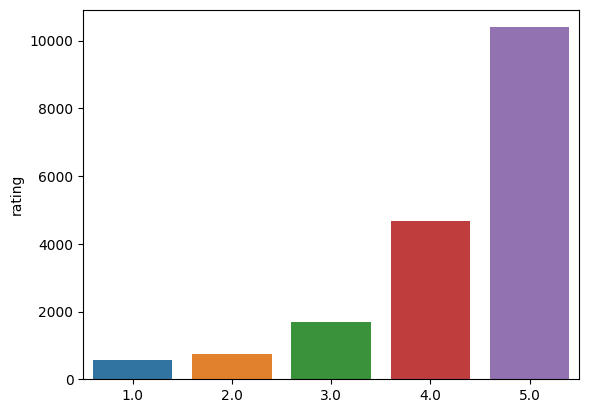

In [140]:
# Create the bar plot and provide observations
sns.barplot(data=df_final, x=rating_counts.index, y=rating_counts)

**Write your observations here:Ratings are left skewed, it has significantly lesser low ratings, in comparision to high ratings, which are over 10,000.**

### **Checking the number of unique users and items in the dataset**

In [141]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final['user_id'].nunique()

637

In [142]:
df_final['prod_id'].nunique()

1970

In [143]:
df_final['user_id'].value_counts()

ADLVFFE4VBT8      136
A3OXHLG6DIBRW8    114
A6FIAB28IS79      107
A680RUE1FDO8B     107
A17BUUBOU0598B     97
                 ... 
A2ZR3YTMEEIIZ4      4
A2CL818RN52NWN      3
A3VL4RXCWNSR3H      3
A2U3OEIK1CUPIK      2
A12DLJESJKM1OQ      1
Name: user_id, Length: 637, dtype: int64

**Write your observations here:we have 637 unique users, 1970 unique products. We have users who have rated more than 100 products.**

### **Users with the most number of ratings**

In [146]:
# Top 10 users based on the number of ratings
top_10_users = df_final.groupby(['user_id']).size().reset_index(name='num_of_ratings').sort_values(by='num_of_ratings', ascending=False).head(10)
top_10_users

,user_id,num_of_ratings
534,ADLVFFE4VBT8,136
451,A3OXHLG6DIBRW8,114
503,A6FIAB28IS79,107
502,A680RUE1FDO8B,107
37,A17BUUBOU0598B,97
332,A2XRMQA6PJ5ZJ8,91
106,A1ODOGXEYECQQ8,91
308,A2UOHALGF2X77Q,84
324,A2WLNSZ9U0T1S3,81
624,AWPODHOB4GFWL,77


**Write your observations here:we have 4 users who rated more than 100 products, which is very useful, since their rating to different products can be helpfull in comparing products.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [148]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean().reset_index(name='avg_rating')
avg_rating

,prod_id,avg_rating
0,B00001P4XA,3.888889
1,B00001P4ZH,4.375000
2,B00001W0DI,4.800000
3,B00001WRSJ,4.222222
4,B00001ZWXA,5.000000
...,...,...
1965,B005JN9310,5.000000
1966,B005JW6WQU,4.875000
1967,B005K7192G,4.833333
1968,B005KAK2FI,4.666667


In [149]:
# Calculate the count of ratings for each product

rate_count = df_final.groupby('prod_id').size().reset_index(name='rate_count')
rate_count

,prod_id,rate_count
0,B00001P4XA,9
1,B00001P4ZH,8
2,B00001W0DI,5
3,B00001WRSJ,9
4,B00001ZWXA,6
...,...,...
1965,B005JN9310,5
1966,B005JW6WQU,8
1967,B005K7192G,6
1968,B005KAK2FI,6


In [150]:
# Create a dataframe with calculated average and count of ratings
mean_and_counts = pd.merge(avg_rating, rate_count, on='prod_id')
mean_and_counts

,prod_id,avg_rating,rate_count
0,B00001P4XA,3.888889,9
1,B00001P4ZH,4.375000,8
2,B00001W0DI,4.800000,5
3,B00001WRSJ,4.222222,9
4,B00001ZWXA,5.000000,6
...,...,...,...
1965,B005JN9310,5.000000,5
1966,B005JW6WQU,4.875000,8
1967,B005K7192G,4.833333,6
1968,B005KAK2FI,4.666667,6


In [151]:
# Sort the dataframe by average of ratings in the descending order
mean_and_counts =mean_and_counts.sort_values(by=['avg_rating', 'rate_count'], ascending=False)

In [152]:
# See the first five records of the "final_rating" dataset
mean_and_counts[:5]

,prod_id,avg_rating,rate_count
1832,B0052SCU8U,5.0,26
1292,B0036Q7MV0,5.0,22
50,B000067RT6,5.0,21
446,B000M2TAN4,5.0,15
1362,B003FVJYF8,5.0,14


In [153]:
df_final.head()

,user_id,prod_id,rating
21022,A3LWC833HQIG7J,B00001P4XA,5.0
21045,A38RMU1Y5TDP9,B00001P4XA,5.0
21311,A33775AIB1A664,B00001P4XA,4.0
21316,ARXU3FESTWMJJ,B00001P4XA,3.0
21342,A3A15L96IYUO6V,B00001P4XA,4.0


In [154]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def prod_to_avoid(df, prod, rating, n=5):
  avg_rating = df.groupby(prod)[rating].mean().reset_index(name='avg_rating')
  rate_count = df.groupby(prod).size().reset_index(name='rate_count')
  mean_and_counts = pd.merge(avg_rating, rate_count, on='prod_id')
  mean_and_counts = mean_and_counts.sort_values(by=['avg_rating', 'rate_count'], ascending=[True, False])
  return  mean_and_counts[:n]



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [157]:
prod_above_50 = mean_and_counts[mean_and_counts['rate_count']>50]
prod_above_50[:5]


,prod_id,avg_rating,rate_count
1348,B003ES5ZUU,4.882979,94
1241,B002WE6D44,4.784314,51
459,B000N99BBC,4.743590,78
1218,B002V88HFE,4.730769,52
1619,B004CLYEDC,4.650794,63


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [158]:
prod_above_100 = mean_and_counts[mean_and_counts['rate_count']>100]
prod_above_100[:5]

,prod_id,avg_rating,rate_count


there are no products with more than 100 interactions.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [159]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [160]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [161]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0,5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.40, random_state=42)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [162]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based':True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above

precision_recall_at_k(sim_user_user)

RMSE: 1.0873
Precision:  0.848
Recall:  0.808
F_1 score:  0.828


**Write your observations here:
- We have calculated **RMSE** to check **how far the overall predicted ratings ** are from the **actual play counts**.
- Intuition of Recall - We are getting a **recall of almost 0.80**, which means out of **all the relevant products, 80% are recommended**.
- Intuition of Precision - We are getting a **precision of almost 0.84**, which means **out of all the recommended products, 84.8% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.828**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [163]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict(400501466, 1400501466, r_ui=2, verbose=True )

user: 400501466  item: 1400501466 r_ui = 2.00   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid=400501466, iid=1400501466, r_ui=2, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:
- As we can see the **predicted rating for this user-item pair is 4.30** based on this user-user-similarity-based baseline model.**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [197]:
# Find unique user_id where prod_id is not equal to "1400501466"
unique_users = df_final[df_final['prod_id'] != "1400501466"]['user_id'].unique()
print(unique_users)


['A3LWC833HQIG7J' 'A38RMU1Y5TDP9' 'A33775AIB1A664' 'ARXU3FESTWMJJ'
 'A3A15L96IYUO6V' 'A3PGVJF37JSHFO' 'A18HE80910BTZI' 'A3J8A5L5AF5TX9'
 'A2WJ5XSE4I9F55' 'A54S9CIUV5VNB' 'A2WB7LZ595CR50' 'A149RNR5RH19YY'
 'A1J75JJ0Q2OEJN' 'A6FIAB28IS79' 'A3077MQTAKOVFZ' 'A1CM4HI4S5P0WO'
 'A3775OP5VTX5ON' 'A1KD8NJPZ01R37' 'A7Y6AVS576M03' 'A18EA7MNLXP9H5'
 'A1U5IJHJK84S54' 'A1B4MIXYVIKMU2' 'A2BMZRO0H7TFCS' 'A2EZTM9WY5B5IL'
 'A34LQ791ACZ0JC' 'A1ZM846Y7AUYD' 'A1U4GOVZWL8ZTL' 'A1F9Z42CFF9IAY'
 'A14JBDSWKPKTZA' 'A506HOOCVL8GW' 'A54SG05AV6S4H' 'A1URXSRV6WDHVY'
 'A2WLNSZ9U0T1S3' 'A2T3S3VTW65VO5' 'A3OXHLG6DIBRW8' 'AHIK7BUXFRMT8'
 'A23GFTVIETX7DS' 'A36K2N527TXXJN' 'A1EH2S92FHWZRP' 'AT2J7H5TRZM8Z'
 'A3NHUQ33CFH3VM' 'AYMD77ITD15PT' 'A1IU7S4HCK1XK0' 'A1MJMYLRTZ76ZX'
 'A2NYK9KWFMJV4Y' 'ALUNVOQRXOZIA' 'AEJAGHLC675A7' 'A259MPG6SOL02P'
 'A1RPTVW5VEOSI' 'A1U5NWJOYH2QQH' 'A231WM2Z2JL0U3' 'A1AQ8JT2A3UWMY'
 'A2SKEQT0WTB954' 'A1R377IPZOKLMM' 'AZAC8O310IK4E' 'A1ODOGXEYECQQ8'
 'A2AEZQ3DGBBLPR' 'A1TDR7Y90SVCHL' 'A3EZEP0FX5BC1P

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [198]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4', 1400501466, r_ui=2, verbose=True )


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 2.00   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=2, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:- As we can see the predicted rating for this user-item pair is 4.30 based on this user-user-similarity-based baseline model.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [166]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline", "msd"],
                              'user_based': [True], "min_support":[2,4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


1.007349045614921
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [199]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True, "min_support":2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=3, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)


RMSE: 0.9997
Precision:  0.835
Recall:  0.831
F_1 score:  0.833


**Write your observations here:__________**

- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is better than the baseline model.** Along with this **the RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [168]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=2, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 2.00   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=2, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [169]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:estimated rating didn't change much.**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [170]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0,5)

[55, 74, 93, 174, 274]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [171]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [173]:
if "A3LDPF5FMB782Z" in df_final['user_id'].values:
    print("User exists in the dataset.")
else:
    print("User does not exist in the dataset.")

User exists in the dataset.


In [174]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final,"A3OXHLG6DIBRW8", 5, sim_user_user_optimized)

In [175]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['user_id', 'predicted_ratings'])

,user_id,predicted_ratings
0,B00005LEN4,5
1,B00007E7JU,5
2,B00020S7XK,5
3,B000FBK3QK,5
4,B000HDJT4S,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [177]:
#Declaring the similarity options.
sim_options = {'name': 'pearson',
               'user_based': False}

#KNN algorithm is used to find desired similar items.
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0303
Precision:  0.831
Recall:  0.827
F_1 score:  0.829


**Write your observations here:**____________

- The baseline model is giving a good F_1 score. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [213]:
rating_value = df_final[(df_final['user_id'] == 'A3LDPF5FMB782Z') & (df_final['prod_id'] == '1400501466')]['rating']
print(rating_value)


Series([], Name: rating, dtype: float64)


In [178]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', "1400501466 ", r_ui=2, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466  r_ui = 2.00   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466 ', r_ui=2, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**____________

- The above output shows that **item-item similarity** based model is making prediction of 4.30.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [179]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4', "1400501466 ", r_ui=2, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466  r_ui = 2.00   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466 ', r_ui=2, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:** it  remains the same.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [180]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0078342284697106
{'k': 10, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [181]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=6, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.0016
Precision:  0.834
Recall:  0.831
F_1 score:  0.832


**Write your observations here:**

- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is much better than the baseline model**. Also, there is a considerable fall in the RMSE value with tuning. Hence the tuned model is doing better than the earlier one.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [182]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=2, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 2.00   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=2, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [183]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.303894425987449, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here: predicted rating remains the same.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [184]:
sim_item_item_optimized.get_neighbors(0, k=5)

[9, 15, 17, 20, 24]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [185]:
if "A1A5KUIIIHFF4U" in df_final['user_id'].values:
    print("User exists in the dataset.")
else:
    print("User does not exist in the dataset.")

User exists in the dataset.


In [186]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)

In [187]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'prediction_ratings'])

,prod_id,prediction_ratings
0,B00001P4XA,4.303894
1,B00001P4ZH,4.303894
2,B00001W0DI,4.303894
3,B00001WRSJ,4.303894
4,B00001ZWXA,4.303894


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [188]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)


# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd, 30)

RMSE: 0.9355
Precision:  0.831
Recall:  0.965
F_1 score:  0.893


**Write your observations here:___________**

- The baseline model with the algorithm is giving a nice F-1 score (almost **89.3%**). It indicates a good performance by the model. The RMSE of the model is 0.93, which is good.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [202]:
df_final.head()

,user_id,prod_id,rating
21022,A3LWC833HQIG7J,B00001P4XA,5.0
21045,A38RMU1Y5TDP9,B00001P4XA,5.0
21311,A33775AIB1A664,B00001P4XA,4.0
21316,ARXU3FESTWMJJ,B00001P4XA,3.0
21342,A3A15L96IYUO6V,B00001P4XA,4.0


In [209]:
filtered_df = df_final[(df_final['user_id'] == 'A3LDPF5FMB782Z') & (df_final['prod_id'] == '1400501466')]
print(filtered_df)

Empty DataFrame
Columns: [user_id, prod_id, rating]
Index: []


In [189]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", '1400501466', r_ui=2, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 2.00   est = 4.32   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=2, est=4.3235757628043245, details={'was_impossible': False})

**Write your observations here: the estimated rating is 4.32, not really signifant.**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [210]:
filtered_df = df_final[(df_final['user_id'] == 'A34BZM6S9L7QI4') & (df_final['prod_id'] == '1400501466')]
print(filtered_df)

Empty DataFrame
Columns: [user_id, prod_id, rating]
Index: []


In [190]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.303894425987449, details={'was_impossible': False})

**Write your observations here: the estimated rating hasn't changed much.**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [191]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.9328288082841086
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [192]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.9261
Precision:  0.849
Recall:  0.827
F_1 score:  0.838


**Write your observations here:_____________**

RMSE is decreased, which is good, but F1_score is also decreased, which is not expected after tuning the model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [193]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=2, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 2.00   est = 4.33   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=2, est=4.326122779759733, details={'was_impossible': False})

In [194]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.303894425987449, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

In this case study, we built recommendation systems using five different algorithms. They are as follows:
- Rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- Model-based (matrix factorization) collaborative filtering  
- Clustering-based recommendation systems

We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.

To demonstrate **"user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been demonstrated. For these algorithms **grid search cross-validation is used to find the best working model**, and using that the **corresponding predictions are made**.



sim_user_user:
RMSE: 1.0873
Precision:  0.848
Recall:  0.808
F_1 score:  0.828

sim_user_user_optimized:
RMSE: 0.9997
Precision:  0.835
Recall:  0.831
F_1 score:  0.833

sim_item_item :
RMSE: 1.0303
Precision:  0.831
Recall:  0.827
F_1 score:  0.829

sim_item_item_optimized:
RMSE: 1.0016
Precision:  0.834
Recall:  0.831
F_1 score:  0.832

svd:
RMSE: 0.9355
Precision:  0.831
Recall:  0.965
F_1 score:  0.893

svd_optimized:
RMSE: 0.9261
Precision:  0.849
Recall:  0.827
F_1 score:  0.838

#### **Proposal for the final solution design:**

We will use the svd  recommendation system as final solution since it is more robust and gives a balanced F_1 score and RMSE value. We have predicted the rating for all the users that have not rated a particular product.